# 단순 선형 회귀 (학습성능개선)

텐서플로우의 학습성능을 개선하기 위해

1. 데이터 표준화 : 학습률 향상에 도움을 준다.
2. 콜백함수 : 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링 하기 위한 도구
## 데이터 정규화(Normalization, 표준화)
### 1) 데이터 정규화의 이해
데이터 정규화란?
모든 데이터가 동일한 정도의 스케일(중요도)로 반영되도록 해 주는 처리

정규화를 해야 하는 이유
머신러닝 알고리즘은 데이터가 가진 feature(특성)들을 비교하여 데이터의 패턴을 찾는다.

이 때, 데이터가 가진 feature의 스케일이 심하게 차이가 나는 경우 수많은 학습 단계를 거쳐서 최적값에 도달하게 된다.

데이터에 정규화 처리를 적용하면 쉽게 최적값에 도달할 수 있으며 학습률을 상대적으로 높여서 사용할 수 있기 때문에 빠르게 훈련시킬 수 있다.

### 2) 데이터 정규화 방법
최소-최대 정규화 (Min-Max Normalization)
모든 feature에 대해 각각의 최소값 0, 최대값 1로, 그리고 다른 값들은 0과 1 사이의 값으로 변환.

예를 들어 어떤 특성의 최소값이 20이고 최대값이 40인 경우, 30이라는 데이터가 있을 경우, 20은 0, 40은 1로 환산되기 때문에 30은 중간치인 0.5로 변환됨.

## 콜백함수

모델의 학습 방향, 저장시점, 학습정지 시점 등에 관한 상황을 모니터링하기 위한 도구
### 콜백함수 사용방법
#### 콜백정의
pyhon
callbacks = [  콜백1, 콜백2, ... 콜백n  ]

# 학습을 위한 fit() 함수에서 callbacks 파라미터에 미리 정의한 리스트를 지정
callbacks = [콜백1, 콜백2, ... , 콜백n]
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 500, callbacks = callbacks)

혹은

model.fit(x_train,y_train,validation_data=(x_val,y_val), epochs = 500, callback =[])

### 콜백함수 종류
#### 1) EarlyStopping()
모델 학습시에 지정된 기간 동안 모니터링하는 평가지표에서 더이상 성능향상이 일어나지 않은 경우 학습을 스스로 중단

EarlyStopping(monitor=평가지표,patience=10,verbose = 1)
- patience : 지정한 수 만큼의 기간에서 평가지표의 향상이 일어나지 않을 경우 학습을 중단( 기간 = 에포크)
예를 들어 patience=10일 때, 10에폭 동안 성능 향상이 일어나지 않으면 학습을 중단. 

즉, 10회 이상 성능향상이 발견되지 않으면 중단함
- verbose : 콜백의 수행과정 노출여부를 지정
- 0: 아무런 표시 하지 않음(기본값)
- 1: 프로그래스바로 표시
- 2: 매 에폭마다 수행과정을 자세하게 출력함.

#### 2) ReduceLROnplateau()
EarlyStopping 과 같이 patience 인자를 지정하여, 지정된 기간동안 평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백

ReduceLROnPlateau(monitor=평가지표,factor=0.1,patience=10,min_lr=0,verbose=1)

- factor : 학습률 조정에 사용되는 값 (새로운 학습률 = factor * 기존 학습률)
- patience: 지정한 수만큼의 기간에서 성능향상이 일어나지 않을 경우 학습률을 조정
- min_lr : 학습률의 하한을 지정
- verbose  콜백의 수행과정 노출여부를 지정


#### 3) ModelCheckpoint()
지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용

ModelCheckpoint(filepaht,monitor=평가지표,verbose=1,save_best_only=True|False,save_weights_only=False)

- filepath: 모델의 저장 경로를 지정
- save_best_only: True인 경우, 가장 성능이 뛰어난 모델만 저장. 그보다 좋지 않은 - 모델의 경우는 덮어쓰지 않는다.
- save_weights_only: 모델의 가중치만 저장

## #01. 패키지 준비하기


In [43]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential      # 순서층을 구성하는 모델 객체 생성 기능
from tensorflow.keras.layers import Dense           # 모델 객체에 학습을 위한 층을 쌓는다.
from tensorflow.keras.optimizers import RMSprop,SGD # 옵티마이저
from tensorflow.keras.losses import mse             # 활성화 함수
import pandas as pd 
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import helper


from sklearn.preprocessing import MinMaxScaler

# 학습에 대한 콜백함수 참조
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

## #02. 데이터 준비

In [44]:
origin = pd.read_excel('https://data.hossam.kr/E04/cars.xlsx')
origin.head()

,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


## #03. 데이터 전처리

In [45]:
origin.isnull().sum()

speed    0
dist     0
dtype: int64

### 데이터 정규화

In [86]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
x = x_scaler.fit_transform(origin[['speed']])
y = y_scaler.fit_transform(origin[['dist']])



<bound method _AxesBase.grid of <Axes: title={'center': '정규화'}>>

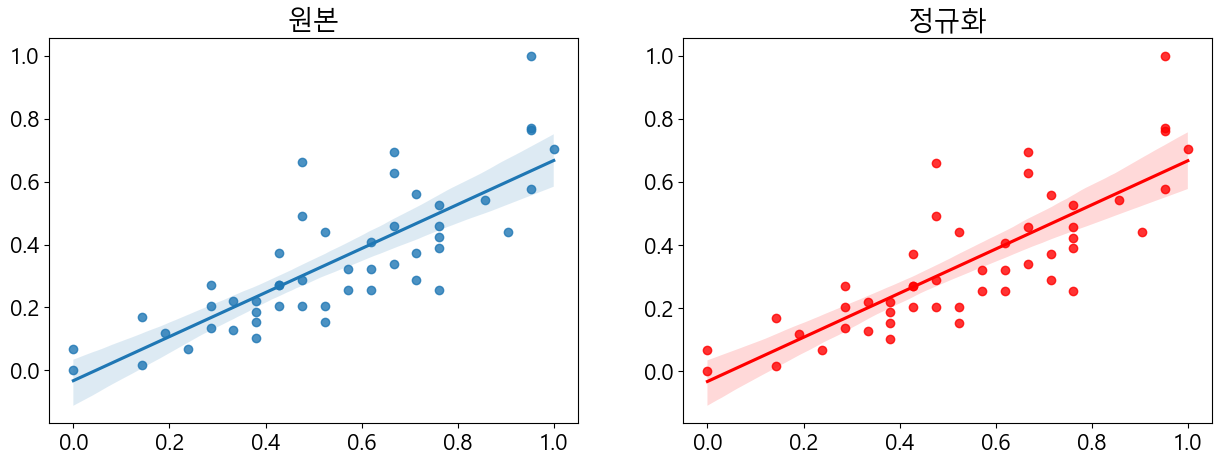

In [87]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

sns.regplot(x=x,y=y,ax=ax1)
ax1.set_title("원본")
ax1.grid

sns.regplot(x=x,y=y,ax=ax2,color='red')
ax2.set_title("정규화")
ax2.grid


## #04. 데이터 확인

In [49]:
df.describe()

,speed,dist
count,50.000000,50.000000
mean,0.542857,0.347288
std,0.251793,0.218385
min,0.000000,0.000000
25%,0.380952,0.203390
50%,0.523810,0.288136
75%,0.714286,0.457627
max,1.000000,1.000000


### 산점도 그래프와 추세선 확인

곡선보다는 선형 분포에 가까우므로 단순 선형 회귀모델을 적용


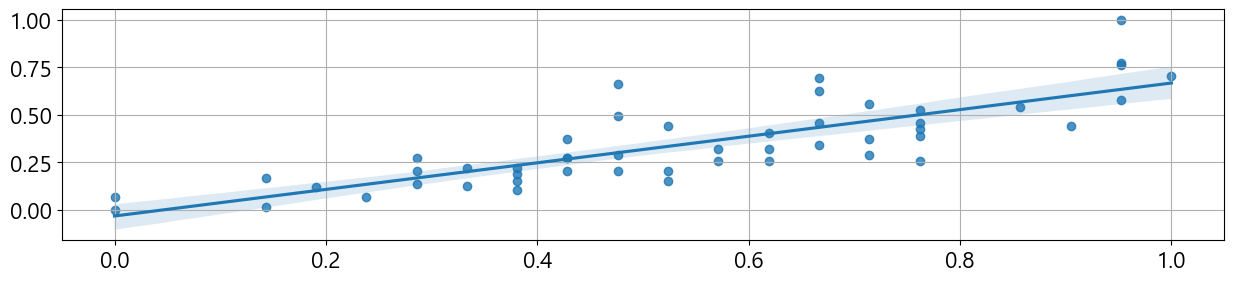

In [88]:
plt.figure(figsize=(15,3))

sns.regplot(x=x,y=y)
plt.grid()
plt.show()
plt.close()

## #05. 데이터 분할

### 랜덤시드 고정

In [89]:
np.random.seed(777)

### 훈련데이터와 종속변수 구분


In [90]:

print('독립변수 : ',x.shape,'종속변수 : ',y.shape)

독립변수 :  (50, 1) 종속변수 :  (50, 1)


In [91]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=777)
print(len(y_train),len(x_test))


35 15


## #06.모델개발
### 1.모델 정의

In [92]:
model = Sequential()
model.add(Dense(10,activation = 'relu',input_shape=(1,)))
model.add(Dense(1,activation='linear'))

model.compile(optimizer=SGD(),loss='mse',metrics = ['mae'])
model.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x00000161AB943FA0>>

### 2. 학습하기

In [93]:
result= model.fit(x_train,y_train, epochs=500,validation_data = (x_test,y_test),callbacks=[
    EarlyStopping(monitor='val_loss',patience=10,verbose=1),
    ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.5,min_lir=0.0001,verbose=1),
    ModelCheckpoint(filepath='reg_check_point.h5',monitor='val_loss',verbose=1,save_best_only=True)
])



result_df = pd.DataFrame(result.history)
result_df['epochs'] = result_df.index + 1
result_df.set_index('epochs',inplace=True)
result_df

Epoch 1/500
1/2 [==============>...............] - ETA: 4s - loss: 0.1698 - mae: 0.3482
Epoch 1: val_loss improved from inf to 0.09726, saving model to reg_check_point.h5


C:\Users\hamin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 10s 6s/step - loss: 0.1605 - mae: 0.3360 - val_loss: 0.0973 - val_mae: 0.2625 - lr: 0.0100
Epoch 2/500
1/2 [==============>...............] - ETA: 0s - loss: 0.1534 - mae: 0.3256
Epoch 2: val_loss improved from 0.09726 to 0.08560, saving model to reg_check_point.h5
2/2 [==============================] - 0s 260ms/step - loss: 0.1425 - mae: 0.3108 - val_loss: 0.0856 - val_mae: 0.2424 - lr: 0.0100
Epoch 3/500
1/2 [==============>...............] - ETA: 0s - loss: 0.1358 - mae: 0.2982
Epoch 3: val_loss improved from 0.08560 to 0.07469, saving model to reg_check_point.h5
2/2 [==============================] - 0s 454ms/step - loss: 0.1273 - mae: 0.2888 - val_loss: 0.0747 - val_mae: 0.2219 - lr: 0.0100
Epoch 4/500
1/2 [==============>...............] - ETA: 0s - loss: 0.1129 - mae: 0.2693
Epoch 4: val_loss improved from 0.07469 to 0.06445, saving model to reg_check_point.h5
2/2 [==============================] - 0s 306ms/step - loss: 0.1129 - mae: 0.2665

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,0.160517,0.336019,0.097263,0.262462,0.01000
2,0.142495,0.310775,0.085598,0.242408,0.01000
3,0.127310,0.288765,0.074688,0.221946,0.01000
4,0.112929,0.266541,0.064448,0.200963,0.01000
5,0.099475,0.244367,0.056724,0.185645,0.01000
6,0.088745,0.226059,0.047872,0.167276,0.01000
7,0.076618,0.203153,0.041791,0.155327,0.01000
8,0.068249,0.188143,0.038527,0.148865,0.01000
9,0.063151,0.178630,0.033409,0.138133,0.01000


### 7) 학습 결과 평가
#### 1. 학습결과 시각화

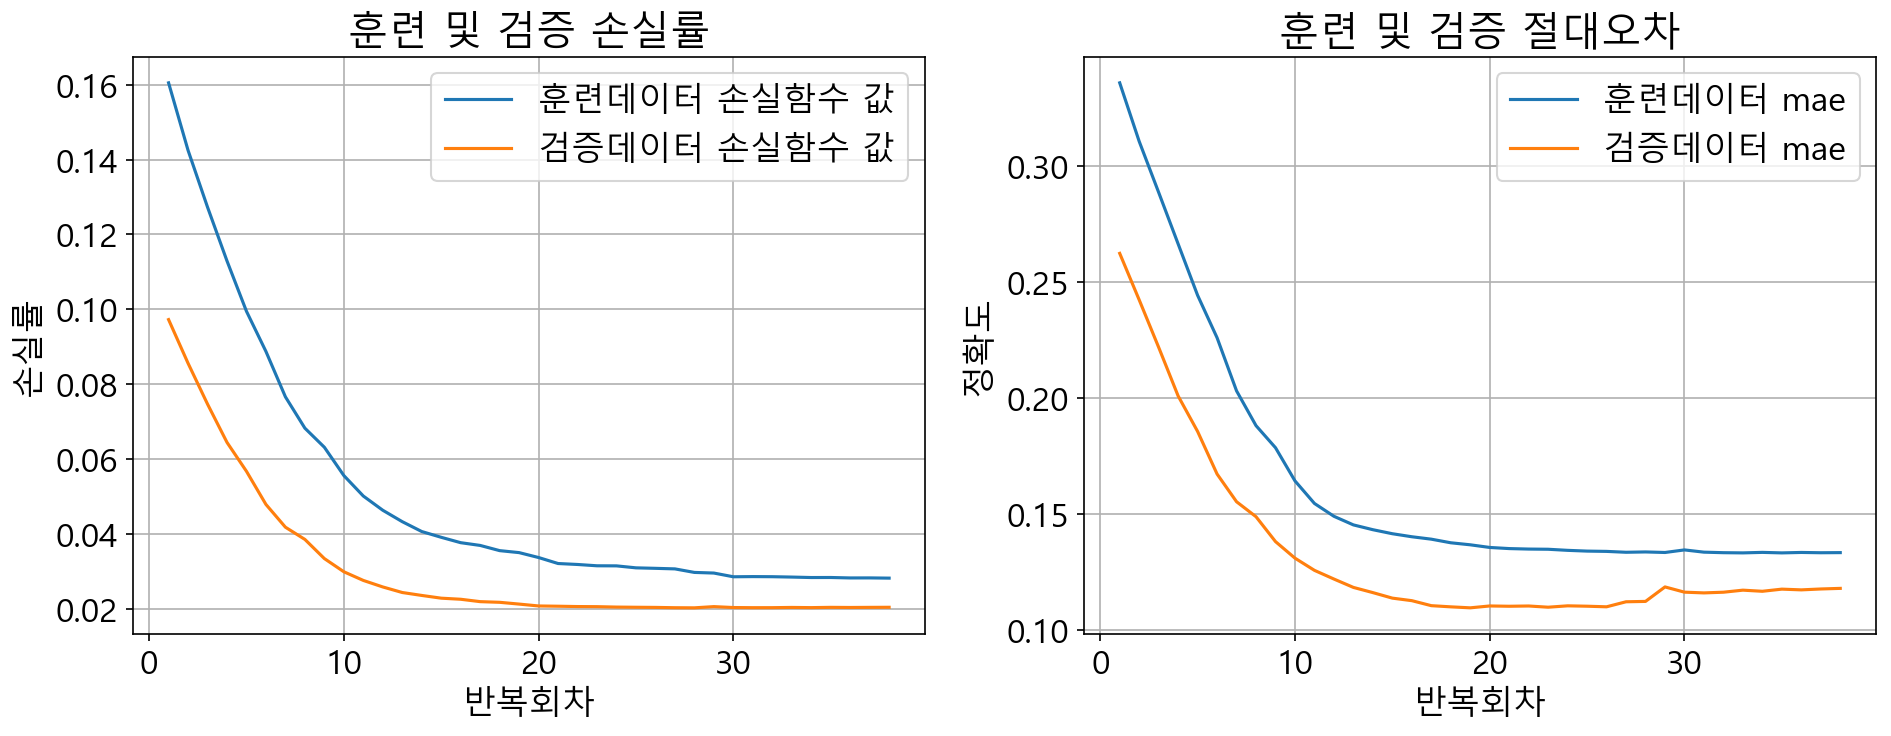

In [94]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증데이터 손실함수 시각화
sns.lineplot(x=result_df.index , y='loss',data = result_df,label = '훈련데이터 손실함수 값',ax=ax1)
sns.lineplot(x=result_df.index , y= 'val_loss',data=result_df,label = '검증데이터 손실함수 값',ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()
# 2) 훈련 및 검증 절대오차 그리기
sns.lineplot(x=result_df.index,y='mae',data=result_df,label='훈련데이터 mae',ax=ax2)
sns.lineplot(x=result_df.index,y='val_mae',data=result_df,label='검증데이터 mae',ax=ax2)

ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

#### 2. 모델 성능 평가

In [95]:
evaluate1 = model.evaluate(x_train,y_train)

evaluate2 = model.evaluate(x_test,y_test)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate2[0], evaluate2[1]))



1/1 [==============================] - 0s 29ms/step - loss: 0.0204 - mae: 0.1180
최종 훈련 손실률: 0.028145, 최종 훈련 절대오차: 0.133418
최종 훈련 손실률: 0.020393, 최종 훈련 절대오차: 0.117957


## #08. 학습 결과 적용
### 1. 테스트 데이터에 대한 예측 결과 산정

In [96]:
results = model.predict(x_test)
print(results)

1/1 [==============================] - 0s 349ms/step
[[0.46606737]
 [0.32143837]
 [0.30697548]
 [0.2925126 ]
 [0.40821576]
 [0.33590126]
 [0.33590126]
 [0.39375287]
 [0.30697548]
 [0.40821576]
 [0.33590126]
 [0.42267865]
 [0.23466098]
 [0.32143837]
 [0.16378003]]


### 2. 결과 데이터 구성

In [97]:
x_test

array([[0.9047619 ],
       [0.42857143],
       [0.38095238],
       [0.33333333],
       [0.71428571],
       [0.47619048],
       [0.47619048],
       [0.66666667],
       [0.38095238],
       [0.71428571],
       [0.47619048],
       [0.76190476],
       [0.14285714],
       [0.42857143],
       [0.        ]])

In [98]:
y_test

array([[0.44067797],
       [0.27118644],
       [0.10169492],
       [0.12711864],
       [0.37288136],
       [0.49152542],
       [0.66101695],
       [0.33898305],
       [0.15254237],
       [0.55932203],
       [0.20338983],
       [0.45762712],
       [0.16949153],
       [0.27118644],
       [0.        ]])

In [99]:
x_test

array([[0.9047619 ],
       [0.42857143],
       [0.38095238],
       [0.33333333],
       [0.71428571],
       [0.47619048],
       [0.47619048],
       [0.66666667],
       [0.38095238],
       [0.71428571],
       [0.47619048],
       [0.76190476],
       [0.14285714],
       [0.42857143],
       [0.        ]])

In [103]:
kdf = pd.DataFrame({
    '검증데이터  ' : x_test.flatten(),
    '실제값  ': y_test.flatten(),
    '예측값' : results.flatten(),
    
})
kdf.columns=['검증데이터','실제값','예측값']
kdf['예측오차'] = kdf['실제값'] - kdf['예측값']
kdf

,검증데이터,실제값,예측값,예측오차
0,0.904762,0.440678,0.466067,-0.025389
1,0.428571,0.271186,0.321438,-0.050252
2,0.380952,0.101695,0.306975,-0.205281
3,0.333333,0.127119,0.292513,-0.165394
4,0.714286,0.372881,0.408216,-0.035334
5,0.476190,0.491525,0.335901,0.155624
6,0.476190,0.661017,0.335901,0.325116
7,0.666667,0.338983,0.393753,-0.054770
8,0.380952,0.152542,0.306975,-0.154433
9,0.714286,0.559322,0.408216,0.151106


In [104]:
kdf.head()

,검증데이터,실제값,예측값,예측오차
0,0.904762,0.440678,0.466067,-0.025389
1,0.428571,0.271186,0.321438,-0.050252
2,0.380952,0.101695,0.306975,-0.205281
3,0.333333,0.127119,0.292513,-0.165394
4,0.714286,0.372881,0.408216,-0.035334


### 3. 실제 결과값과 머신러닝에 의한 예측값 비교

<Axes: xlabel='검증데이터', ylabel='예측값'>

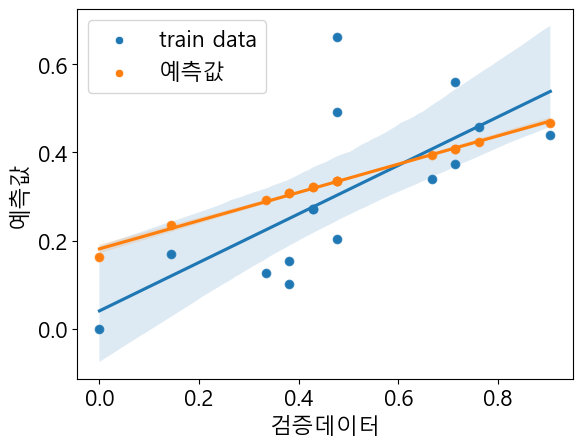

In [105]:

## 관측치 시각화
sns.scatterplot(x=kdf['검증데이터'],y=kdf['실제값'],label = 'train data')
# ## 관측치 선그래프
sns.regplot(x=kdf['검증데이터'],y=kdf['실제값'])

## 예측치 시각화
sns.scatterplot(x=kdf['검증데이터'],y=kdf['예측값'],label = '예측값')
# ## 예측치 선그래프
sns.regplot(x=kdf['검증데이터'],y=kdf['예측값'])



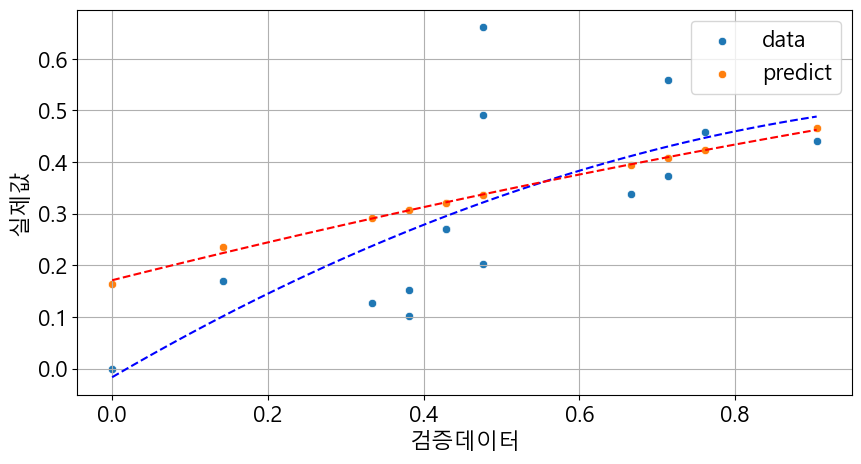

In [106]:
helper.regplot(x_left=kdf['검증데이터'], y_left=kdf['실제값'], y_left_pred=kdf['예측값'])


### 3. 임의의 값에 대한 머신러닝 예측 결과


In [107]:
speed= [50] 
my_speed = pd.DataFrame(speed,columns=['speed'])
my_speed

,speed
0,50


In [108]:

my_speed[['speed']] = scaler.fit_transform(my_speed[['speed']])
results= model.predict(my_speed['speed'])
results
# print("속도가 %d인 자동차의 제동거리는 %d로 예상됩니다." % (my_speed, results))

1/1 [==============================] - 0s 244ms/step


array([[0.16378003]], dtype=float32)

In [112]:
result_final = scaler.inverse_transform(results)

In [113]:
result_final

array([[50.16378]], dtype=float32)